In [1]:
# Edgar new data Mar 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

from loguru import logger
from sklearn.linear_model import TweedieRegressor
from preprocessing import *

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX TITAN X


In [2]:

parent_path = Path('./data/biological/EB145/')
stim_path = parent_path 
run_path = parent_path 
save_path = Path('./save/trained_models/EB145/')

# area_ID_ephys = np.load(run_path / 'area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
# dff_run = np.load(run_path / 'dff_run.npy')                    # (294, 32727) GCaMP when running
dff_stim = np.load(stim_path /'Img.npy')                  # (294, 94696) GCaMP when stimulated 
# spks_run = np.load(run_path / 'spks_run.npy')                  # (106, 32727)
spks_stim = np.load(stim_path /'Ephys.npy')                # (106, 94096)
# speed_run = np.load(run_path / 'speed_run.npy')                # (32727,) max 13

# speed_triggers_ephys_run = np.load(run_path / 'speed_triggers_ephys_run.npy')  # (56322)
# speed_triggers_img_run = np.load(run_path / 'speed_triggers_img_run.npy')      # (56322)
# stim_ID = np.load(stim_path /'stim_ID.npy')
# stim_ID_resolved = np.load(stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
# stim_time = np.load(stim_path /'stim_triggers.npy')            # (300, )

2024-03-25 16:52:31.689 | INFO     | preprocessing:convolve_spikes:26 - Detected Ephys file with 127 neurons and 35000 bins.
2024-03-25 16:52:31.939 | INFO     | preprocessing:convolve_spikes:51 - Produced convolved rates at sigma=0.1 with 127 neurons and 35000 bins.


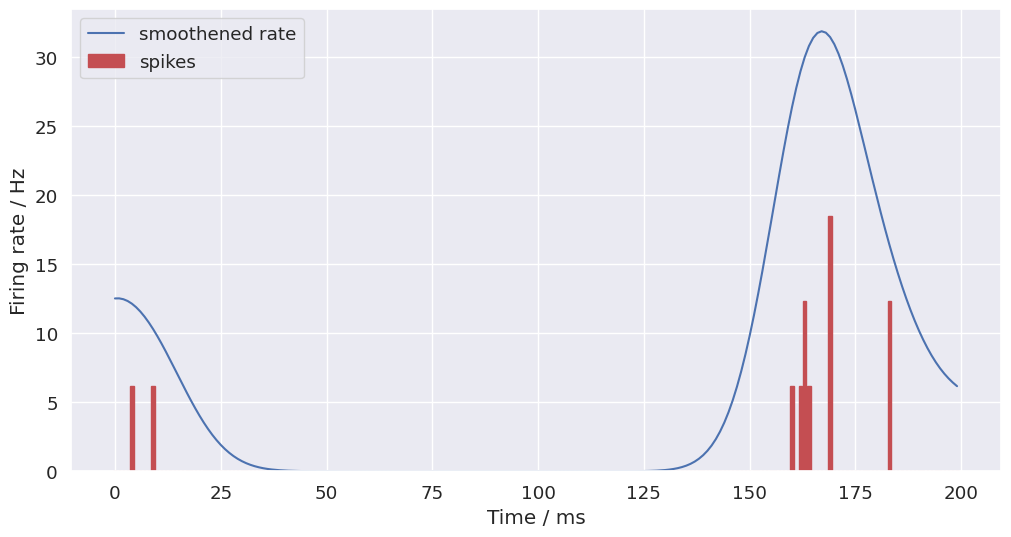

In [3]:
spks_stim_rates, n_output_neurons, n_bins = convolve_spikes(spks_stim)
plot_convolution_example(spks_stim_rates, spks_stim,seed=seed)
input_dim = dff_stim.shape[0]
assert n_bins == dff_stim.shape[1]

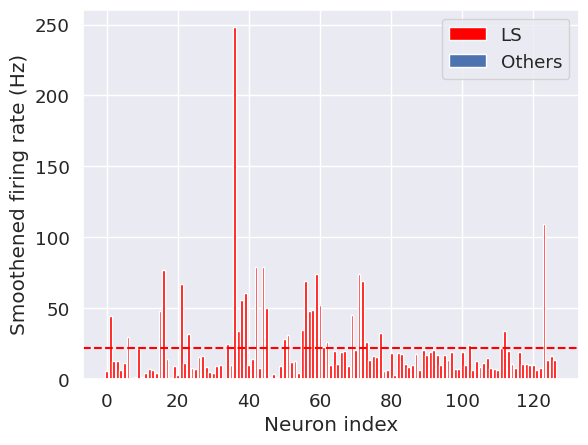

LS neuron firing rate: 22.25628662109375 Hz
non-LS neuron firing rate: nan Hz


In [4]:
mask1 = np.array([True for _ in range(n_output_neurons)])
mask2 = np.array([False for _ in range(n_output_neurons)])

plt.bar(np.arange(spks_stim_rates.shape[1])[mask1], spks_stim_rates.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates.shape[1])[mask2], spks_stim_rates.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates.mean(0)[mask2].mean()} Hz')

In [5]:
inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(dff_stim, spks_stim_rates, has_stim=True, stim_time=[], stim_ID=[], cutoff_size=1, offset=-3, tsteps=15)
sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=500, seed=seed)
test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

In [6]:
LS_neuron_idx = np.arange(n_output_neurons)

# randomise valid idx
n_non_stim = len(Y_train)
valid_idx = np.random.choice(np.arange(len(Y_train)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y_train))) - set(valid_idx))))


# forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
# backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
# random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
# non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [7]:
# 8 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
Y_valid_LS = Y_train[valid_idx,:,:][..., LS_neuron_idx]

output_dim = len(LS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_LS)
train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_LS)
valid_dataloader_LS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)
del train_dataset, test_dataset, valid_dataset

# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability

In [10]:
_run = True
from bayes_opt import BayesianOptimization
from models import TransformerOneStep
from train import train_transformer, eval_transformer
from utils import count_parameters

LS_param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=False,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    LS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=123)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run:
    run_bayes_opt(pbounds = {'d_model':(100, 2000), 'num_heads':(1, 30), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=200, n_iter=200)
    np.save(f'./data/trained_models/EB145/EB145-stim-LS-param_counts.npy', np.array(LS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:33<00:00,  1.63it/s]


| 1         | -221.2    | 1.423e+03 | 357.5     | 1.907     | 16.99     |


 78%|███████▊  | 196/250 [08:13<02:16,  2.52s/it]


| 2         | -500.8    | 1.467e+03 | 480.8     | 4.923     | 20.86     |


 22%|██▏       | 55/250 [00:43<02:33,  1.27it/s]


KeyboardInterrupt: 

In [12]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 42        | -199.5    | 1.207e+03 | 833.4     | 2.348     | 27.9      |


d_model = 1423
num_heads = 20
hidden_dim = 480
n_layers = 4

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)


# assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
# assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
# assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
# assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

In [13]:
# import wandb
# wandb.login()
# wandb.init(project='approx_brain')

return_dict = None # intialise as None
n_cycles = 10
for _ in range(n_cycles):
    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)
    num_epochs = 500

    from train import train_transformer, eval_transformer

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=train_dataloader_LS,
                test_loader=test_dataloader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=False,
                # [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1663.821116795067


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:02<19:17,  2.32s/it]

Epoch 1: training loss 1754.3716430664062, eval loss 1512.094127249929. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:04<20:28,  2.59s/it]

Epoch 26: training loss 713.0305480957031, eval loss 633.1239740748966. Time elapsed: 0 h 1 m 4 s.


 10%|█         | 51/500 [02:09<19:16,  2.58s/it]

Epoch 51: training loss 507.69102478027344, eval loss 468.6562194768602. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<18:13,  2.58s/it]

Epoch 76: training loss 440.5072021484375, eval loss 407.1949886582695. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:18<17:26,  2.62s/it]

Epoch 101: training loss 404.7261199951172, eval loss 374.1397865269939. Time elapsed: 0 h 4 m 18 s.


 25%|██▌       | 126/500 [05:22<15:59,  2.57s/it]

Epoch 126: training loss 399.53448486328125, eval loss 374.18798406206656. Time elapsed: 0 h 5 m 22 s.


 30%|███       | 151/500 [06:26<14:47,  2.54s/it]

Epoch 151: training loss 398.9834442138672, eval loss 374.89744584104733. Time elapsed: 0 h 6 m 26 s.


 35%|███▌      | 176/500 [07:29<13:43,  2.54s/it]

Epoch 176: training loss 398.38307189941406, eval loss 374.8369184324103. Time elapsed: 0 h 7 m 30 s.


 39%|███▉      | 196/500 [08:23<13:01,  2.57s/it]


Initial eval loss: 374.8410649152632


  0%|          | 1/500 [00:02<21:06,  2.54s/it]

Epoch 1: training loss 403.5326232910156, eval loss 369.08594985853586. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:05,  2.54s/it]

Epoch 26: training loss 415.682861328125, eval loss 391.5914584600248. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:02,  2.54s/it]

Epoch 51: training loss 433.45208740234375, eval loss 405.5412767332621. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<18:07,  2.56s/it]

Epoch 76: training loss 435.0312805175781, eval loss 403.6427527246864. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:54,  2.54s/it]

Epoch 101: training loss 433.71388244628906, eval loss 403.40060024363584. Time elapsed: 0 h 4 m 17 s.


 22%|██▏       | 110/500 [04:42<16:42,  2.57s/it]


Initial eval loss: 403.38193673465366


  0%|          | 1/500 [00:02<21:19,  2.56s/it]

Epoch 1: training loss 438.9612579345703, eval loss 445.6279513100243. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:06,  2.54s/it]

Epoch 26: training loss 467.4488220214844, eval loss 436.7499029793745. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:10<19:12,  2.57s/it]

Epoch 51: training loss 471.275146484375, eval loss 441.5733975270792. Time elapsed: 0 h 2 m 10 s.


 15%|█▌        | 76/500 [03:13<17:58,  2.54s/it]

Epoch 76: training loss 469.15882873535156, eval loss 439.28469574961457. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:54,  2.54s/it]

Epoch 101: training loss 469.27171325683594, eval loss 440.8339847616449. Time elapsed: 0 h 4 m 17 s.


 22%|██▏       | 112/500 [04:47<16:37,  2.57s/it]


Initial eval loss: 440.78601810023554


  0%|          | 1/500 [00:02<21:07,  2.54s/it]

Epoch 1: training loss 473.1529083251953, eval loss 446.63052476003475. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:07,  2.55s/it]

Epoch 26: training loss 476.314208984375, eval loss 450.2966006004354. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:00,  2.54s/it]

Epoch 51: training loss 475.0096435546875, eval loss 453.1545433522205. Time elapsed: 0 h 2 m 10 s.


 15%|█▌        | 76/500 [03:13<17:58,  2.54s/it]

Epoch 76: training loss 474.38108825683594, eval loss 450.8981845172863. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:54,  2.54s/it]

Epoch 101: training loss 474.4576873779297, eval loss 451.02681083301735. Time elapsed: 0 h 4 m 17 s.


 22%|██▏       | 110/500 [04:42<16:42,  2.57s/it]


Initial eval loss: 451.03816873644547


  0%|          | 1/500 [00:02<21:09,  2.54s/it]

Epoch 1: training loss 474.1817626953125, eval loss 429.7917241182868. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:07,  2.55s/it]

Epoch 26: training loss 481.175048828125, eval loss 450.88859793238277. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:02,  2.54s/it]

Epoch 51: training loss 478.98887634277344, eval loss 450.02127106911. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<17:57,  2.54s/it]

Epoch 76: training loss 478.4684295654297, eval loss 450.20691169945354. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:55,  2.55s/it]

Epoch 101: training loss 481.6126251220703, eval loss 450.2577894921857. Time elapsed: 0 h 4 m 17 s.


 22%|██▏       | 110/500 [04:42<16:42,  2.57s/it]


Initial eval loss: 450.2687031754847


  0%|          | 1/500 [00:02<21:12,  2.55s/it]

Epoch 1: training loss 485.0408935546875, eval loss 453.2456000670599. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:04,  2.54s/it]

Epoch 26: training loss 484.1127624511719, eval loss 449.9185562775526. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:01,  2.54s/it]

Epoch 51: training loss 481.4276580810547, eval loss 450.0028424750611. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<17:57,  2.54s/it]

Epoch 76: training loss 480.54144287109375, eval loss 450.10693229078794. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:57,  2.55s/it]

Epoch 101: training loss 481.49700927734375, eval loss 450.18139053835944. Time elapsed: 0 h 4 m 17 s.


 23%|██▎       | 114/500 [04:52<16:30,  2.57s/it]


Initial eval loss: 450.16434874478773


  0%|          | 1/500 [00:02<21:09,  2.54s/it]

Epoch 1: training loss 482.90037536621094, eval loss 447.97394552505415. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:31,  2.60s/it]

Epoch 26: training loss 413.7283020019531, eval loss 420.8597052385438. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:10<19:09,  2.56s/it]

Epoch 51: training loss 435.200927734375, eval loss 442.62646779528893. Time elapsed: 0 h 2 m 10 s.


 15%|█▌        | 76/500 [03:14<18:00,  2.55s/it]

Epoch 76: training loss 442.17359924316406, eval loss 441.61315429624074. Time elapsed: 0 h 3 m 14 s.


 20%|██        | 101/500 [04:17<16:55,  2.54s/it]

Epoch 101: training loss 441.2200927734375, eval loss 440.82979422124316. Time elapsed: 0 h 4 m 17 s.


 25%|██▌       | 126/500 [05:21<15:54,  2.55s/it]

Epoch 126: training loss 441.3621063232422, eval loss 442.72808917099564. Time elapsed: 0 h 5 m 21 s.


 26%|██▌       | 130/500 [05:34<15:51,  2.57s/it]


Initial eval loss: 441.29650688047684


  0%|          | 1/500 [00:02<21:09,  2.54s/it]

Epoch 1: training loss 441.2252655029297, eval loss 435.3624789048856. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:05,  2.54s/it]

Epoch 26: training loss 424.51446533203125, eval loss 418.8292454965178. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:00,  2.54s/it]

Epoch 51: training loss 415.565673828125, eval loss 404.64875559446403. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<17:57,  2.54s/it]

Epoch 76: training loss 415.7309265136719, eval loss 404.3141165126071. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:54,  2.54s/it]

Epoch 101: training loss 416.2783508300781, eval loss 406.19569933547564. Time elapsed: 0 h 4 m 17 s.


 24%|██▍       | 121/500 [05:10<16:12,  2.57s/it]


Initial eval loss: 406.1768558315566


  0%|          | 1/500 [00:02<21:08,  2.54s/it]

Epoch 1: training loss 414.836669921875, eval loss 409.5671378329629. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:14,  2.56s/it]

Epoch 26: training loss 409.6202850341797, eval loss 400.98792000561417. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:01,  2.54s/it]

Epoch 51: training loss 410.2447967529297, eval loss 407.6879624885977. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<17:58,  2.54s/it]

Epoch 76: training loss 411.3234558105469, eval loss 408.3781719928517. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:54,  2.54s/it]

Epoch 101: training loss 409.9790954589844, eval loss 408.4998340947957. Time elapsed: 0 h 4 m 17 s.


 25%|██▌       | 126/500 [05:20<15:51,  2.54s/it]

Epoch 126: training loss 412.1231231689453, eval loss 408.47631482339045. Time elapsed: 0 h 5 m 20 s.


 26%|██▌       | 128/500 [05:28<15:54,  2.57s/it]


Initial eval loss: 408.4742911286598


  0%|          | 1/500 [00:02<21:10,  2.55s/it]

Epoch 1: training loss 414.65283203125, eval loss 394.7624416238174. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [01:06<20:05,  2.54s/it]

Epoch 26: training loss 411.2856750488281, eval loss 406.9988095093102. Time elapsed: 0 h 1 m 6 s.


 10%|█         | 51/500 [02:09<19:02,  2.54s/it]

Epoch 51: training loss 413.18614196777344, eval loss 411.12734519533484. Time elapsed: 0 h 2 m 9 s.


 15%|█▌        | 76/500 [03:13<17:58,  2.54s/it]

Epoch 76: training loss 414.068115234375, eval loss 410.6441468046864. Time elapsed: 0 h 3 m 13 s.


 20%|██        | 101/500 [04:17<16:56,  2.55s/it]

Epoch 101: training loss 411.6311492919922, eval loss 411.17844477974745. Time elapsed: 0 h 4 m 17 s.


 22%|██▏       | 110/500 [04:42<16:42,  2.57s/it]


In [13]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': 15,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs}
        }

torch.save(return_dict['best_eval_params'], save_path / f'EB145-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk3.pth')
with open(save_path / f'EB145-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk3.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/EB145-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk3')

TypeError: 'NoneType' object is not subscriptable

In [14]:
with open(save_path / f'EB145-stim-LS-transformer-param-metadata-304-19-948-4-mk3.pkl', 'rb') as f:
    data = pickle.load(f)
best_eval_params = torch.load(save_path /f'EB145-stim-LS-transformer-param-304-19-948-4-mk3.pth')
DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    # print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    # print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    # print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    # print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

RuntimeError: Error(s) in loading state_dict for TransformerOneStep:
	Unexpected key(s) in state_dict: "encoder.layers.2.self_attn.in_proj_weight", "encoder.layers.2.self_attn.in_proj_bias", "encoder.layers.2.self_attn.out_proj.weight", "encoder.layers.2.self_attn.out_proj.bias", "encoder.layers.2.linear1.weight", "encoder.layers.2.linear1.bias", "encoder.layers.2.linear2.weight", "encoder.layers.2.linear2.bias", "encoder.layers.2.norm1.weight", "encoder.layers.2.norm1.bias", "encoder.layers.2.norm2.weight", "encoder.layers.2.norm2.bias", "encoder.layers.3.self_attn.in_proj_weight", "encoder.layers.3.self_attn.in_proj_bias", "encoder.layers.3.self_attn.out_proj.weight", "encoder.layers.3.self_attn.out_proj.bias", "encoder.layers.3.linear1.weight", "encoder.layers.3.linear1.bias", "encoder.layers.3.linear2.weight", "encoder.layers.3.linear2.bias", "encoder.layers.3.norm1.weight", "encoder.layers.3.norm1.bias", "encoder.layers.3.norm2.weight", "encoder.layers.3.norm2.bias". 
	size mismatch for embedding_layer.weight: copying a param with shape torch.Size([304, 373]) from checkpoint, the shape in current model is torch.Size([1188, 373]).
	size mismatch for embedding_layer.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for pe.pe: copying a param with shape torch.Size([30, 1, 304]) from checkpoint, the shape in current model is torch.Size([30, 1, 1188]).
	size mismatch for encoder.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([912, 304]) from checkpoint, the shape in current model is torch.Size([3564, 1188]).
	size mismatch for encoder.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([912]) from checkpoint, the shape in current model is torch.Size([3564]).
	size mismatch for encoder.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([304, 304]) from checkpoint, the shape in current model is torch.Size([1188, 1188]).
	size mismatch for encoder.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.0.linear1.weight: copying a param with shape torch.Size([948, 304]) from checkpoint, the shape in current model is torch.Size([833, 1188]).
	size mismatch for encoder.layers.0.linear1.bias: copying a param with shape torch.Size([948]) from checkpoint, the shape in current model is torch.Size([833]).
	size mismatch for encoder.layers.0.linear2.weight: copying a param with shape torch.Size([304, 948]) from checkpoint, the shape in current model is torch.Size([1188, 833]).
	size mismatch for encoder.layers.0.linear2.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.0.norm1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.0.norm1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.0.norm2.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.0.norm2.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.1.self_attn.in_proj_weight: copying a param with shape torch.Size([912, 304]) from checkpoint, the shape in current model is torch.Size([3564, 1188]).
	size mismatch for encoder.layers.1.self_attn.in_proj_bias: copying a param with shape torch.Size([912]) from checkpoint, the shape in current model is torch.Size([3564]).
	size mismatch for encoder.layers.1.self_attn.out_proj.weight: copying a param with shape torch.Size([304, 304]) from checkpoint, the shape in current model is torch.Size([1188, 1188]).
	size mismatch for encoder.layers.1.self_attn.out_proj.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.1.linear1.weight: copying a param with shape torch.Size([948, 304]) from checkpoint, the shape in current model is torch.Size([833, 1188]).
	size mismatch for encoder.layers.1.linear1.bias: copying a param with shape torch.Size([948]) from checkpoint, the shape in current model is torch.Size([833]).
	size mismatch for encoder.layers.1.linear2.weight: copying a param with shape torch.Size([304, 948]) from checkpoint, the shape in current model is torch.Size([1188, 833]).
	size mismatch for encoder.layers.1.linear2.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.1.norm1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.1.norm1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.1.norm2.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for encoder.layers.1.norm2.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([1188]).
	size mismatch for decoder.weight: copying a param with shape torch.Size([127, 304]) from checkpoint, the shape in current model is torch.Size([127, 1188]).

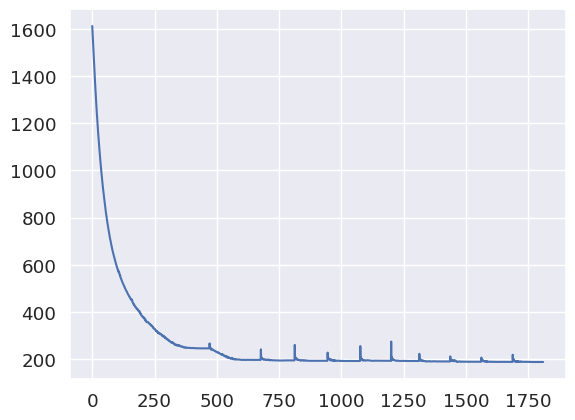

In [22]:
plt.plot(return_dict['eval_losses'])

In [23]:
# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (500, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='auto')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    # logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')

logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

# logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
# logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
# logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
# logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

np.save(save_path / 'EB145-stim-LS-glm-losses.npy', glm_LS_losses)

2024-03-21 19:05:18.489 | INFO     | __main__:<module>:10 - Loss for LS neuron No 0: 23.72254150390625 (Hz^2).
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
2024-03-21 19:05:32.109 | INFO     | __main__:<module>:10 - Loss for LS neuron No 1: 364.548671875 (Hz^2).
2024-03-21 19:05:46.351 | INFO     | __main__:<module>:10 - Loss for LS neuron No 2: 66.3545068359375 (Hz^2).
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

In [25]:
np.save(save_path / 'EB145-stim-LS-glm-losses.npy', glm_LS_losses)

In [26]:
glm_LS_losses.mean()

263.76944